In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import shap
import scikitplot as skplt
from mistune.plugins.math import math
from pyspark.sql.functions import avg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

from scipy.stats import ks_2samp
from scipy.stats import describe
from imblearn.over_sampling import SMOTENC
from collections import Counter
from IPython.display import display

%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
dataset_base_path = r'E:\PycharmProjects\pythonProject1\iiot2024'


In [3]:
types = {
    'ts': 'float64',  # Timestamp, likely in float format
    'flow_duration': 'float32',  # Same as original
    'Header_Length': 'int64',  # Same as original 'header_length'
    'Source IP': 'object',  # IP addresses as strings
    'Destination IP': 'object',  # IP addresses as strings
    'Source Port': 'int32',  # Ports can be stored as integers
    'Destination Port': 'int32',  # Same as source port
    'Protocol Type': 'int8',  # Assuming small integer range for protocol types
    'Protocol_name': 'object',  # Protocol names as strings
    'Duration': 'float32',  # Same as original 'duration'
    'Rate': 'float32',  # Replacing 'rate'
    'Srate': 'float32',  # Same as original 'srate'
    'Drate': 'float32',  # Same as original 'drate'
    'fin_flag_number': 'uint8',  # Same as original
    'syn_flag_number': 'uint8',  # Same as original
    'rst_flag_number': 'uint8',  # Same as original
    'psh_flag_number': 'uint8',  # Same as original
    'ack_flag_number': 'uint8',  # Same as original
    'urg_flag_number': 'uint8',  # New, inferred from context
    'ece_flag_number': 'uint8',  # Same as original
    'cwr_flag_number': 'uint8',  # Same as original
    'ack_count': 'float32',  # Same as original
    'syn_count': 'float32',  # Same as original
    'fin_count': 'float32',  # Same as original
    'urg_count': 'float32',  # Same as original
    'rst_count': 'float32',  # Same as original
    'max_duration': 'float32',  # New field inferred from context
    'min_duration': 'float32',  # New field inferred from context
    'sum_duration': 'float32',  # New field inferred from context
    'average_duration': 'float32',  # New field inferred from context
    'std_duration': 'float32',  # New field inferred from context
    'CoAP': 'uint8',  # New field, protocol flag
    'HTTP': 'uint8',  # Protocol flag
    'HTTPS': 'uint8',  # Protocol flag
    'DNS': 'uint8',  # Protocol flag
    'Telnet': 'uint8',  # Protocol flag
    'SMTP': 'uint8',  # Protocol flag
    'SSH': 'uint8',  # Protocol flag
    'IRC': 'uint8',  # Protocol flag
    'TCP': 'uint8',  # Protocol flag
    'UDP': 'uint8',  # Protocol flag
    'DHCP': 'uint8',  # Protocol flag
    'ARP': 'uint8',  # Protocol flag
    'ICMP': 'uint8',  # Protocol flag
    'IGMP': 'uint8',  # Protocol flag
    'IPv': 'uint8',  # Protocol flag
    'LLC': 'uint8',  # Protocol flag
    'Tot sum': 'float32',  # Replacing 'tot_sum'
    'Min': 'float32',  # Replacing 'min'
    'Max': 'float32',  # Replacing 'max'
    'AVG': 'float32',  # Replacing 'avg'
    'Std': 'float32',  # Replacing 'std'
    'Tot size': 'float32',  # Replacing 'tot_size'
    'IAT': 'float32',  # Replacing 'iat'
    'Number': 'float32',  # Replacing 'number'
    'MAC': 'object',  # Likely MAC address, stored as a string
    'Magnitue': 'float32',  # Inferred from context
    'Radius': 'float32',  # Same as original 'radius'
    'Covariance': 'float32',  # Same as original 'covariance'
    'Variance': 'float32',  # Same as original 'variance'
    'Weight': 'float32',  # Same as original 'weight'
    'DS status': 'uint8',  # New field, inferred from context
    'Fragments': 'uint8',  # New field, inferred from context
    'Sequence number': 'int64',  # New field, inferred from context
    'Protocol Version': 'int8',  # New field, inferred from context
    'flow_idle_time': 'float32',  # New field, inferred from context
    'flow_active_time': 'float32',  # New field, inferred from context
    'label': 'object',  # Same as original
    'subLabel': 'object',  # New field, inferred from context
    'subLabelCat': 'object'  # New field, inferred from context
}

def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values

    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))

    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)


    return df

In [4]:
csv_files = glob.glob(os.path.join(dataset_base_path, '*.csv'))

df = load_dataset(csv_files, types)
df

,ts,flow_duration,Header_Length,Source IP,Destination IP,Source Port,Destination Port,Protocol Type,Protocol_name,Duration,...,Weight,DS status,Fragments,Sequence number,Protocol Version,flow_idle_time,flow_active_time,label,subLabel,subLabelCat
0,1.701426e+09,0.000000,66,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,1.0,0,0,0,0,1.701426e+09,0.000000,0,0,0
1,1.701426e+09,0.002112,132,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,4.0,0,0,0,0,2.112150e-03,0.002112,0,0,0
2,1.701426e+09,0.002328,198,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,9.0,0,0,0,0,2.160072e-04,0.002328,0,0,0
3,1.701426e+09,0.004329,264,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,16.0,0,0,0,0,2.001047e-03,0.004329,0,0,0
4,1.701426e+09,0.009495,330,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,25.0,0,0,0,0,5.165815e-03,0.009495,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9536818,1.701550e+09,2.018212,5460,172.16.66.128,239.255.255.250,41544,1900,17,UDP,1.0,...,100.0,0,0,0,0,2.312660e-05,2.018212,0,0,0
9536819,1.701550e+09,0.021296,1432,172.16.66.128,172.16.64.128,502,55784,6,TCP,64.0,...,121.0,0,0,0,0,2.112150e-03,0.021296,0,0,0
9536820,1.701550e+09,2.018227,5670,172.16.66.128,239.255.255.250,41544,1900,17,UDP,1.0,...,144.0,0,0,0,0,1.478195e-05,2.018227,0,0,0
9536821,1.701550e+09,2.018277,5880,172.16.66.128,239.255.255.250,41544,1900,17,UDP,1.0,...,169.0,0,0,0,0,5.006790e-05,2.018277,0,0,0


In [5]:
import socket
import struct
import pandas as pd

# دالة لتحويل IP إلى عدد صحيح
def ip_to_int(ip_address):
    try:
        return struct.unpack("!I", socket.inet_aton(ip_address))[0]
    except socket.error:
        return None  # في حال وجود خطأ في عنوان الـ IP

# نفترض أن لدينا DataFrame يحتوي على عناوين IP


# تحويل عناوين IP إلى أرقام صحيحة
df['Source IP (int)'] = df['Source IP'].apply(ip_to_int)
df['Destination IP (int)'] = df['Destination IP'].apply(ip_to_int)

# عرض النتائج
print(df)


                   ts  flow_duration  Header_Length      Source IP  \
0        1.701426e+09       0.000000             66  172.16.64.128   
1        1.701426e+09       0.002112            132  172.16.64.128   
2        1.701426e+09       0.002328            198  172.16.64.128   
3        1.701426e+09       0.004329            264  172.16.64.128   
4        1.701426e+09       0.009495            330  172.16.64.128   
...               ...            ...            ...            ...   
9536818  1.701550e+09       2.018212           5460  172.16.66.128   
9536819  1.701550e+09       0.021296           1432  172.16.66.128   
9536820  1.701550e+09       2.018227           5670  172.16.66.128   
9536821  1.701550e+09       2.018277           5880  172.16.66.128   
9536822  1.701550e+09       2.018348           6090  172.16.66.128   

          Destination IP  Source Port  Destination Port  Protocol Type  \
0          172.16.66.128        41750               502              6   
1          

In [6]:
X = df.drop(columns=['label','subLabel','subLabelCat','Source IP','Destination IP'])
y = df[['label']]

In [7]:
y.label.value_counts()

label
0    21598215
1        1004
Name: count, dtype: int64

In [8]:
X

,ts,flow_duration,Header_Length,Source Port,Destination Port,Protocol Type,Protocol_name,Duration,Rate,Srate,...,Variance,Weight,DS status,Fragments,Sequence number,Protocol Version,flow_idle_time,flow_active_time,Source IP (int),Destination IP (int)
0,1.701426e+09,0.000000,66,41750,502,6,TCP,64.0,0.000000,0.000000,...,0.0,1.0,0,0,0,0,1.701426e+09,0.000000,2886746240,2886746752
1,1.701426e+09,0.002112,132,41750,502,6,TCP,64.0,946.902344,946.902344,...,0.0,4.0,0,0,0,0,2.112150e-03,0.002112,2886746240,2886746752
2,1.701426e+09,0.002328,198,41750,502,6,TCP,64.0,1288.572632,1288.572632,...,0.0,9.0,0,0,0,0,2.160072e-04,0.002328,2886746240,2886746752
3,1.701426e+09,0.004329,264,41750,502,6,TCP,64.0,923.957275,923.957275,...,0.0,16.0,0,0,0,0,2.001047e-03,0.004329,2886746240,2886746752
4,1.701426e+09,0.009495,330,41750,502,6,TCP,64.0,526.591858,526.591858,...,0.0,25.0,0,0,0,0,5.165815e-03,0.009495,2886746240,2886746752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9536818,1.701550e+09,2.018212,5460,41544,1900,17,UDP,1.0,12.882689,12.882689,...,1.0,100.0,0,0,0,0,2.312660e-05,2.018212,2886746752,4026531834
9536819,1.701550e+09,0.021296,1432,502,55784,6,TCP,64.0,939.142456,939.142456,...,1.0,121.0,0,0,0,0,2.112150e-03,0.021296,2886746752,2886746240
9536820,1.701550e+09,2.018227,5670,41544,1900,17,UDP,1.0,13.378079,13.378079,...,1.0,144.0,0,0,0,0,1.478195e-05,2.018227,2886746752,4026531834
9536821,1.701550e+09,2.018277,5880,41544,1900,17,UDP,1.0,13.873220,13.873220,...,1.0,169.0,0,0,0,0,5.006790e-05,2.018277,2886746752,4026531834


In [9]:
y.value_counts()

label
0        21598215
1            1004
Name: count, dtype: int64

In [9]:
stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

4                 CoAP
8                 DHCP
9            DS status
0                Drate
10           Fragments
7                  IRC
12    Protocol Version
6                 SMTP
11     Sequence number
5               Telnet
3      cwr_flag_number
2      ece_flag_number
1      urg_flag_number
dtype: object

In [10]:
X = X.drop(columns=features_no_variance)


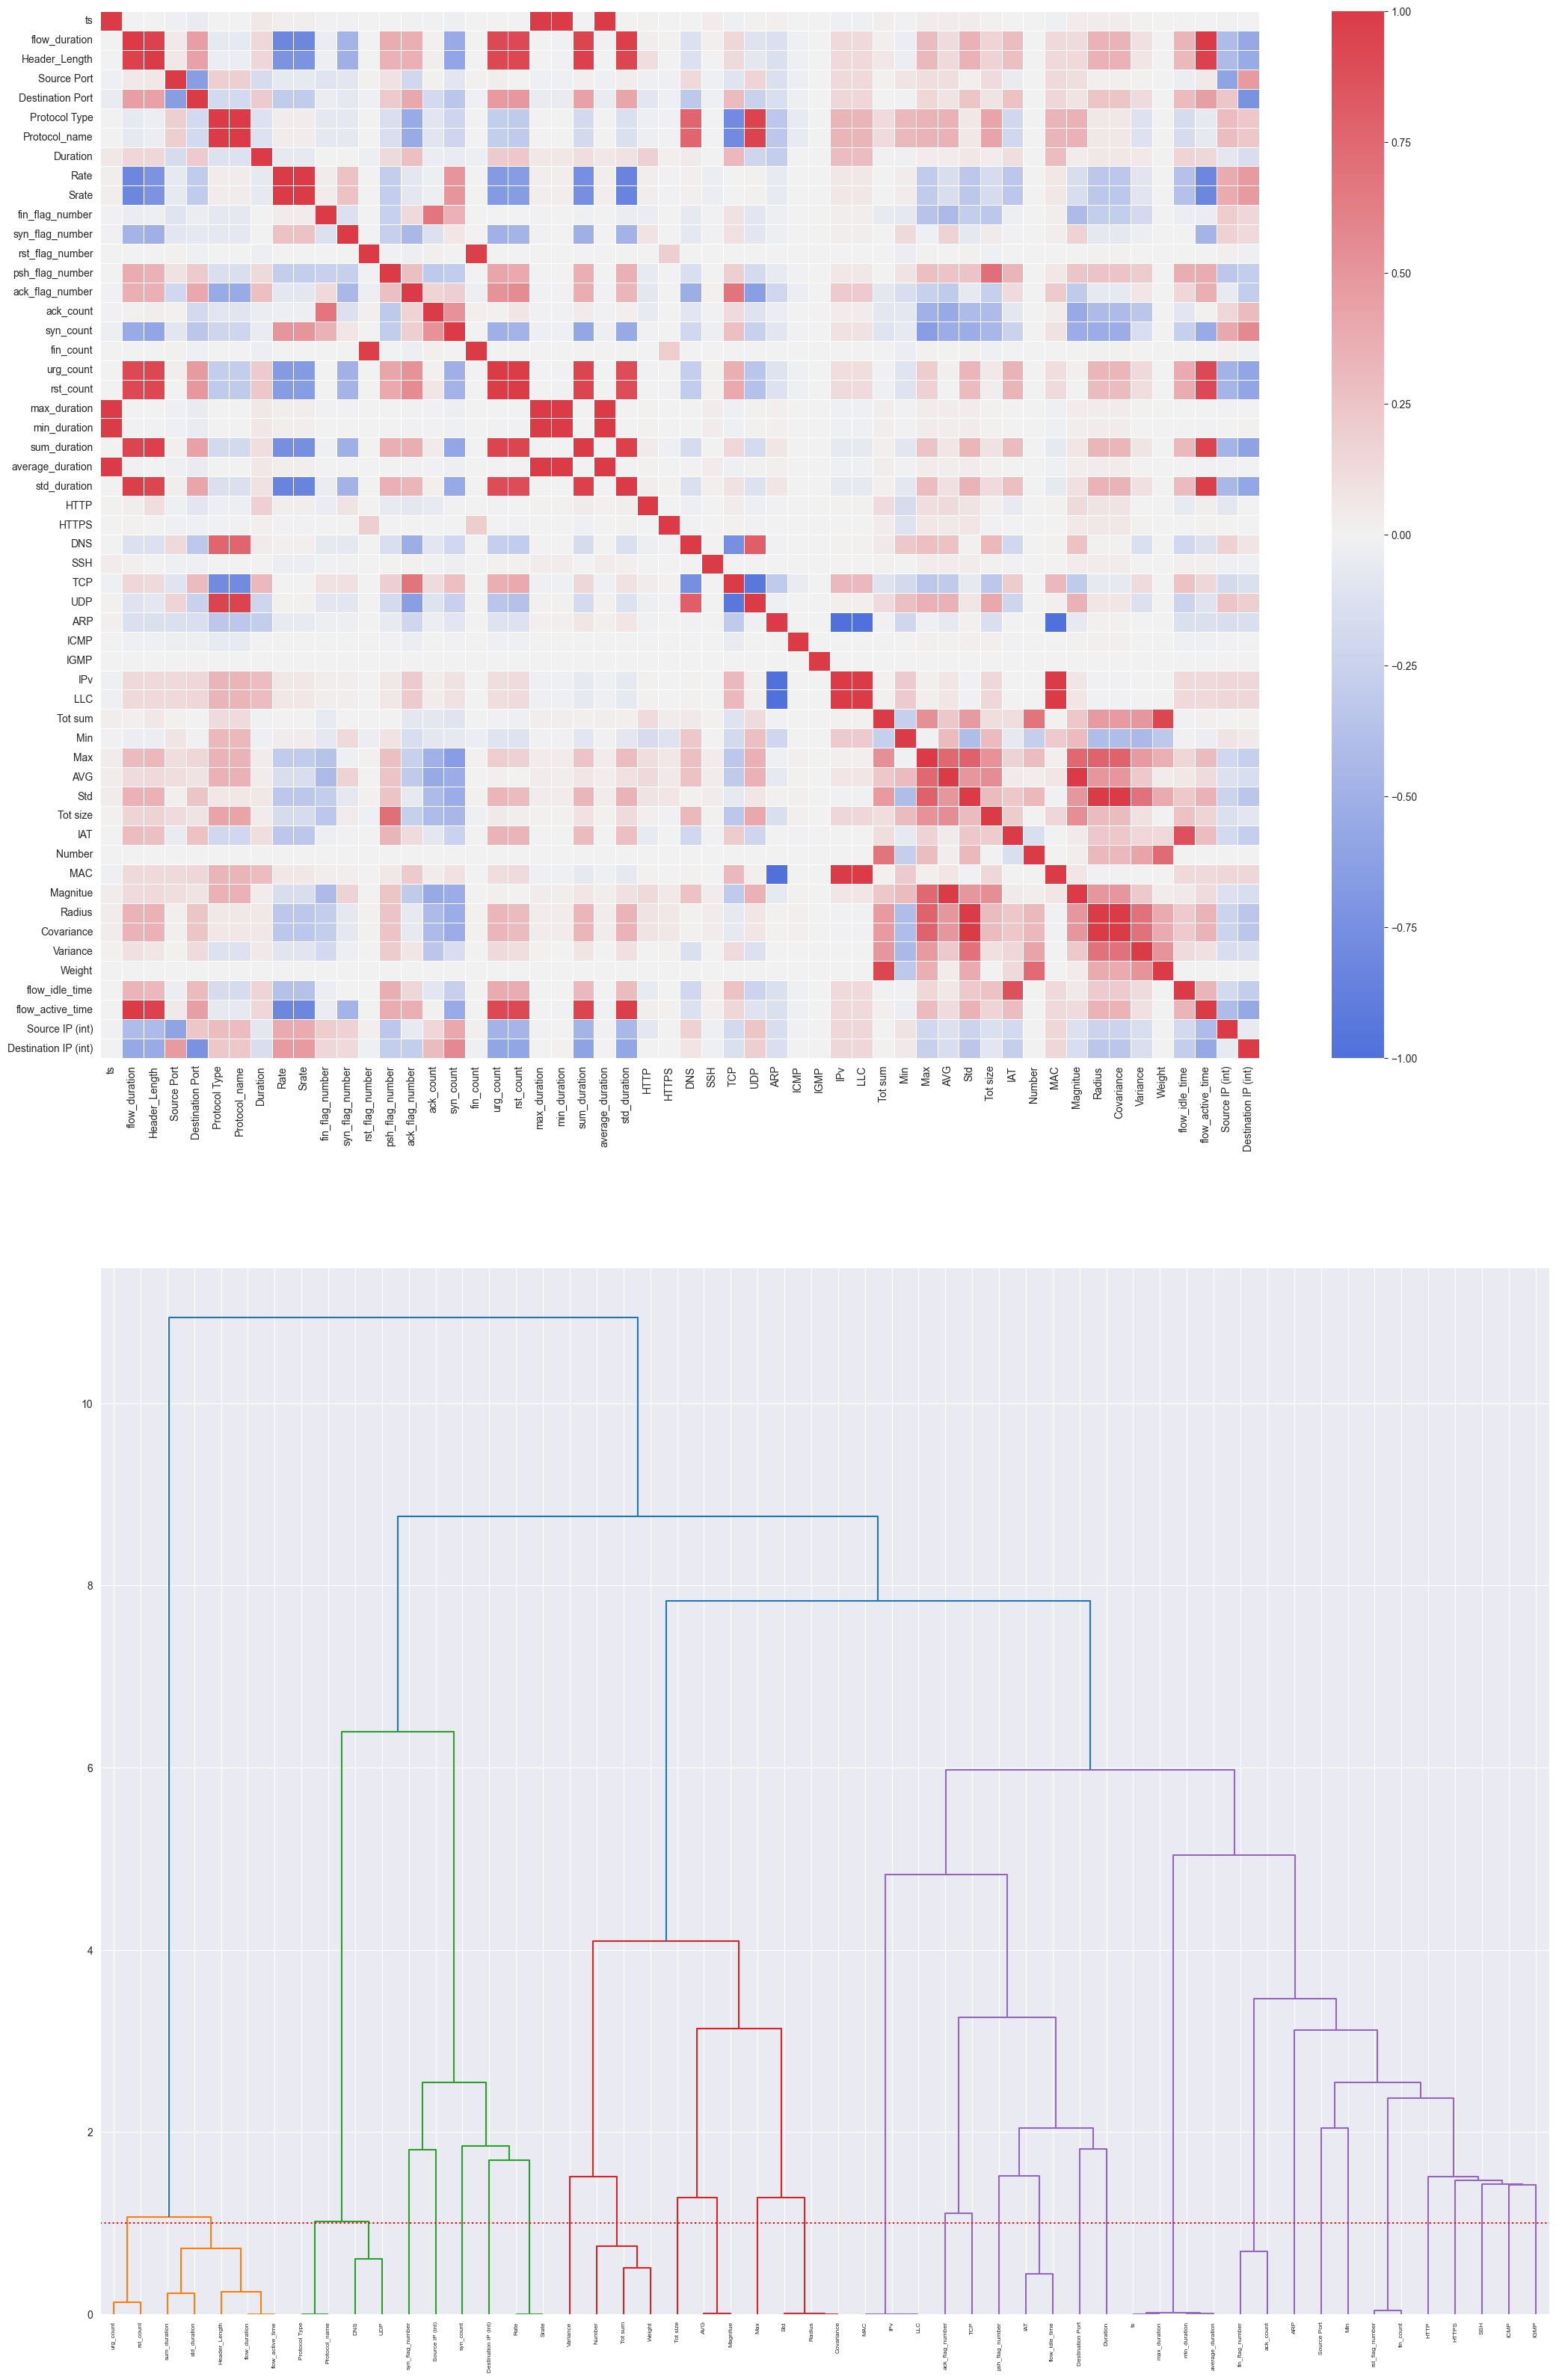

In [11]:
cluster_threshold = 1

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 40))

sns.heatmap(corr, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True), ax=ax1)

dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns, ax=ax2, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax2.plot([0, 1000], [cluster_threshold, cluster_threshold], ':r')
plt.show()

In [12]:
cluster_ids = hierarchy.fcluster(corr_linkage, cluster_threshold, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = X.columns[selected_features].tolist()

print('Selected features:')
pd.Series(selected_features)

Selected features:


0                       ts
1            flow_duration
2              Source Port
3         Destination Port
4            Protocol Type
5                 Duration
6                     Rate
7          fin_flag_number
8          syn_flag_number
9          rst_flag_number
10         psh_flag_number
11         ack_flag_number
12               syn_count
13               urg_count
14                    HTTP
15                   HTTPS
16                     DNS
17                     SSH
18                     TCP
19                     ARP
20                    ICMP
21                    IGMP
22                     IPv
23                 Tot sum
24                     Min
25                     Max
26                     AVG
27                     Std
28                Tot size
29                     IAT
30                Variance
31         Source IP (int)
32    Destination IP (int)
dtype: object

In [13]:
X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 33


test1

In [7]:
selected_features = [
    'ts', 'flow_duration', 'Source Port', 'Destination Port', 'Protocol Type', 'Duration', 'Rate',
    'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'syn_count', 'urg_count', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'TCP', 'ARP', 'ICMP', 'IGMP', 'IPv',
    'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Variance', 'Source IP (int)', 'Destination IP (int)'
]

In [8]:
X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 33


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)



In [10]:
unique_classes = np.unique(y_train)
class_weights = {cls: len(y_train) / np.sum(y_train == cls) for cls in unique_classes}
print(f"Class weights: {class_weights}")

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


Class weights: {'0': label    1.000046
dtype: float64, '1': label    21518.524284
dtype: float64}


In [11]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=1300,
    learning_rate=0.2,
    depth=9,
    loss_function='MultiClass',
    task_type='GPU',
    verbose=20,
    random_seed=42,
    l2_leaf_reg=2,
    border_count=512,
    early_stopping_rounds=150,
    eval_metric='TotalF1',
    leaf_estimation_iterations=10,
    bagging_temperature=1.0,
    class_weights=list(class_weights.values()),



)


# Train the model
model.fit(X_train, y_train)


0:	learn: 0.9999721	total: 217ms	remaining: 4m 41s
20:	learn: 0.9999883	total: 1.94s	remaining: 1m 58s
40:	learn: 0.9999921	total: 3.02s	remaining: 1m 32s
60:	learn: 0.9999930	total: 3.86s	remaining: 1m 18s
80:	learn: 0.9999939	total: 4.74s	remaining: 1m 11s
100:	learn: 0.9999966	total: 6.3s	remaining: 1m 14s
120:	learn: 0.9999993	total: 8.84s	remaining: 1m 26s
140:	learn: 0.9999998	total: 11.5s	remaining: 1m 34s
160:	learn: 1.0000000	total: 14.1s	remaining: 1m 40s
180:	learn: 1.0000000	total: 16.7s	remaining: 1m 43s
200:	learn: 1.0000000	total: 19.2s	remaining: 1m 45s
220:	learn: 1.0000000	total: 21.8s	remaining: 1m 46s
240:	learn: 1.0000000	total: 24.4s	remaining: 1m 47s
260:	learn: 1.0000000	total: 27s	remaining: 1m 47s
280:	learn: 1.0000000	total: 29.6s	remaining: 1m 47s
300:	learn: 1.0000000	total: 32.2s	remaining: 1m 46s
320:	learn: 1.0000000	total: 34.8s	remaining: 1m 46s
340:	learn: 1.0000000	total: 37.4s	remaining: 1m 45s
360:	learn: 1.0000000	total: 40s	remaining: 1m 43s
380:

In [12]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4319643
           1       1.00      1.00      1.00       201

    accuracy                           1.00   4319844
   macro avg       1.00      1.00      1.00   4319844
weighted avg       1.00      1.00      1.00   4319844



In [14]:
class_names = [
    "0",
    "1"

]


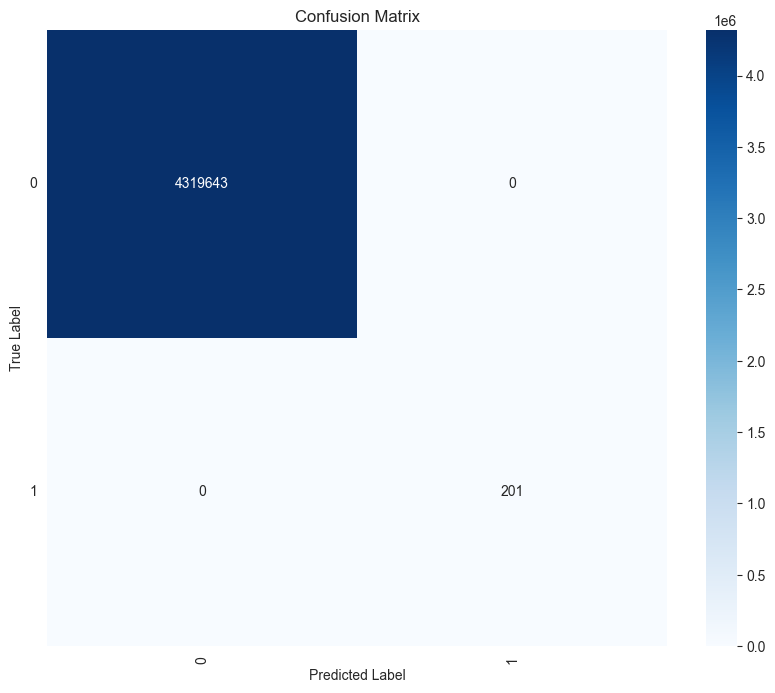

In [15]:
from sklearn.metrics import confusion_matrix


# Ensure y_test has the same type as y_pred
y_test = y_test.astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)  # Rotate X-axis labels for readability if they are long
plt.yticks(rotation=0)
plt.show()


In [33]:
y_test.shape

(4319844, 1)

In [34]:
y_pred.shape

(4319844,)

In [20]:
target_names = [      0,1
]


In [13]:
from prettytable import PrettyTable
from sklearn.metrics import precision_recall_fscore_support

def display_metrics_table(y_true, y_pred):
    # Convert y_true to numpy array if it's a DataFrame
    if hasattr(y_true, 'values'):
        y_true = y_true.values

    # Flatten y_true to match the shape of y_pred
    y_true = y_true.ravel()

    # Convert y_true to integers to match y_pred
    y_true = y_true.astype(int)

    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

    # Create a table
    table = PrettyTable()
    table.field_names = ["Class", "Precision", "Recall", "F1-score", "Support"]

    for i, (p, r, f, s) in enumerate(zip(precision, recall, f1, support)):
        table.add_row([f"Class {i}", f"{p:.6f}", f"{r:.6f}", f"{f:.6f}", s])

    print(table)

    # Calculate accuracy
    accuracy = (y_pred == y_true).sum() / len(y_true)
    print(f"\nOverall Accuracy: {accuracy:.6f}")

# Convert y_test to a numpy array if necessary, and flatten it
if hasattr(y_test, 'values'):
    y_test = y_test.values

y_test = y_test.ravel()

# Convert y_test from strings to integers
y_test = y_test.astype(int)

y_pred = model.predict(X_test).ravel()
y_pred = y_pred.astype(int)

display_metrics_table(y_test, y_pred)


+---------+-----------+----------+----------+---------+
|  Class  | Precision |  Recall  | F1-score | Support |
+---------+-----------+----------+----------+---------+
| Class 0 |  1.000000 | 1.000000 | 1.000000 | 4319643 |
| Class 1 |  1.000000 | 1.000000 | 1.000000 |   201   |
+---------+-----------+----------+----------+---------+

Overall Accuracy: 1.000000


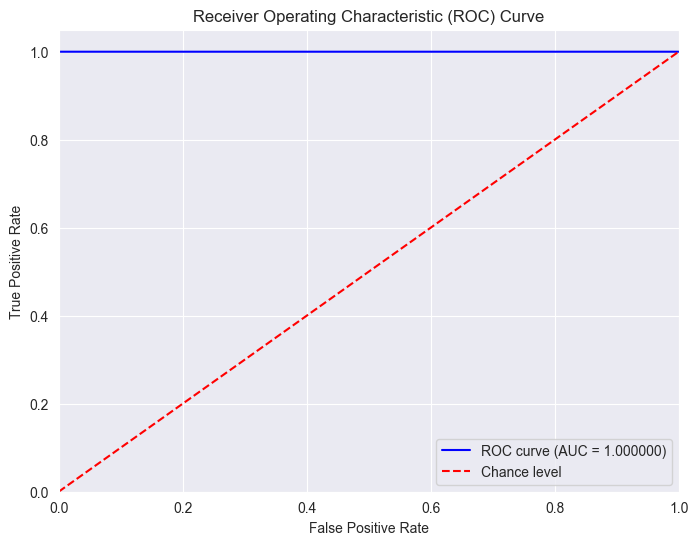

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve (specify pos_label='1')
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='1')

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.6f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Chance level')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


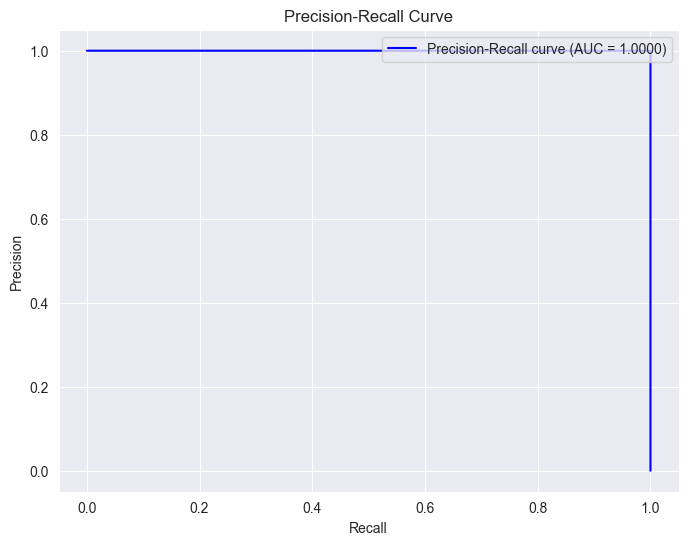

In [18]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Compute predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds (specify pos_label='1')
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label='1')

# Calculate AUC for the precision-recall curve
pr_auc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


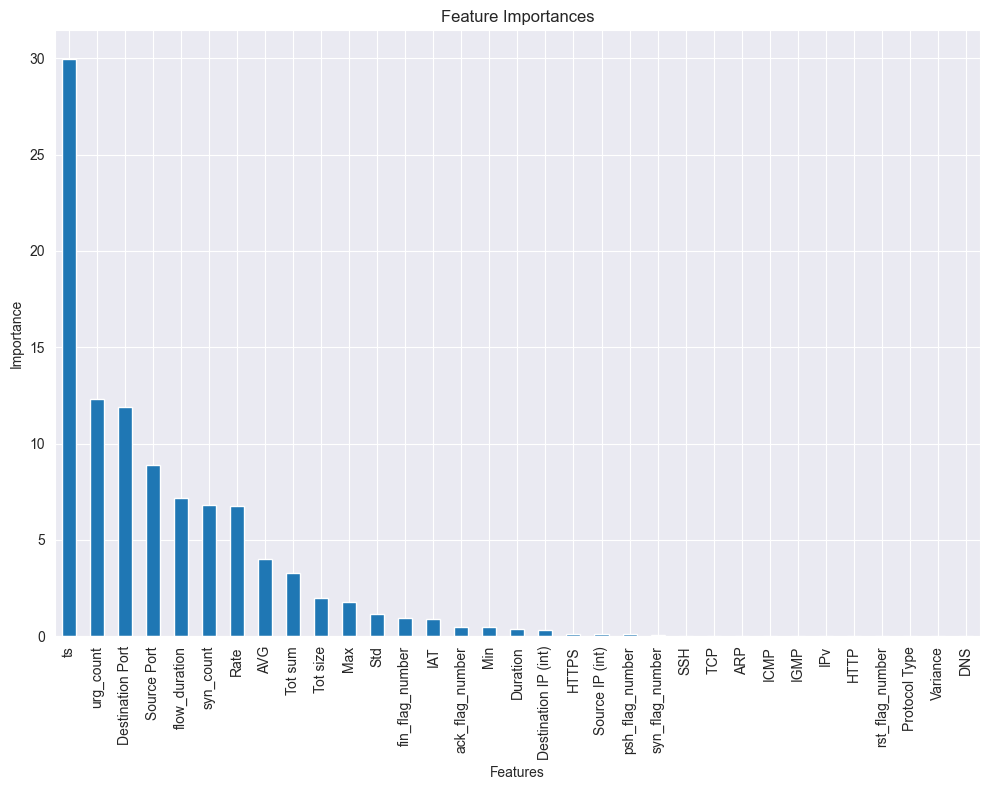

In [19]:
import matplotlib.pyplot as plt
import pandas as pd


# Get feature importances
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Create a pandas Series to view and sort the importances along with their corresponding feature names
feature_importances_series = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
feature_importances_series.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()  # Adjust layout to fit all feature names
plt.show()


In [20]:
model.save_model("finalcatboost.pkl")


In [21]:
import pandas as pd


feature_importances = model.get_feature_importance()
feature_names = X_train.columns

feature_importances_series = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

# Convert the Series into a DataFrame
feature_importances_df = feature_importances_series.reset_index()
feature_importances_df.columns = ['Feature', 'Importance']

# Display the feature importances as a table
print(feature_importances_df)


                 Feature  Importance
0                     ts   29.945899
1              urg_count   12.329332
2       Destination Port   11.879409
3            Source Port    8.877850
4          flow_duration    7.195975
5              syn_count    6.793175
6                   Rate    6.777759
7                    AVG    3.998043
8                Tot sum    3.271823
9               Tot size    2.010203
10                   Max    1.765528
11                   Std    1.144883
12       fin_flag_number    0.977661
13                   IAT    0.922191
14       ack_flag_number    0.495493
15                   Min    0.473291
16              Duration    0.381402
17  Destination IP (int)    0.314495
18                 HTTPS    0.143088
19       Source IP (int)    0.105938
20       psh_flag_number    0.097479
21       syn_flag_number    0.082172
22                   SSH    0.016910
23                   TCP    0.000000
24                   ARP    0.000000
25                  ICMP    0.000000
2

In [22]:
third_length = len(X_test)
X_sample = X_test[:third_length]


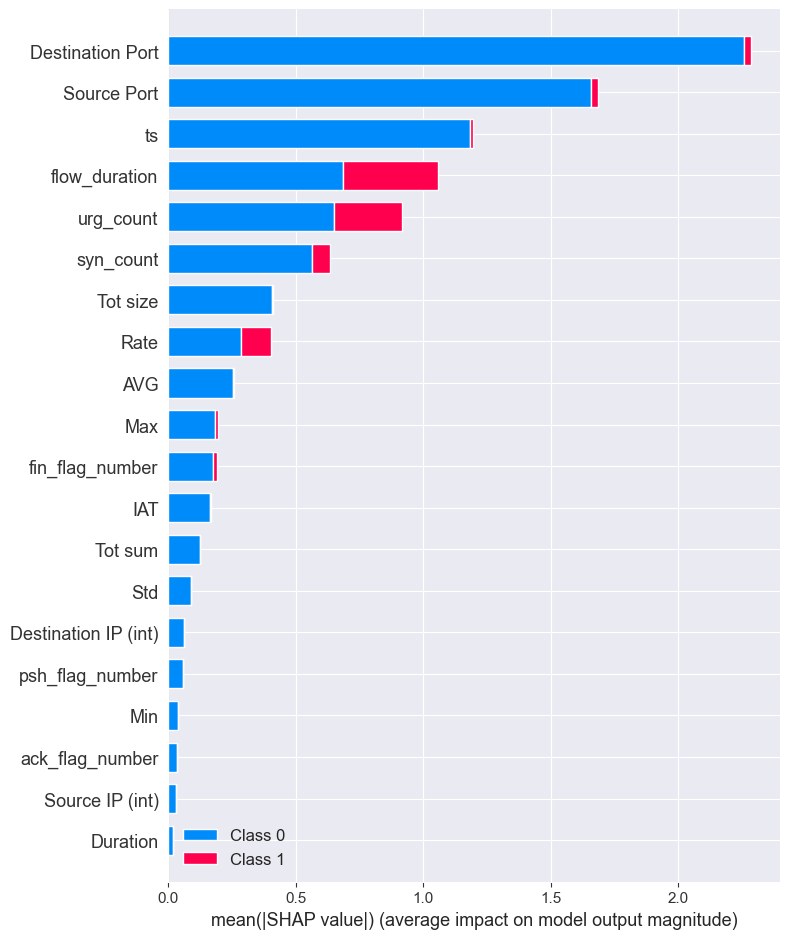

In [23]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample)


In [24]:
import shap
import pandas as pd



# Number of classes
num_classes = len(shap_values)

# Process each class's SHAP values separately
for i in range(num_classes):
    # Convert to DataFrame
    shap_df = pd.DataFrame(shap_values[i], columns=X_sample.columns)

    # Summarize SHAP values for each feature
    shap_summary = shap_df.abs().mean().sort_values(ascending=False)

    # Convert summary to DataFrame
    shap_summary_df = pd.DataFrame(shap_summary, columns=[f'Mean SHAP Value Class {i}'])

    # Display the DataFrame
    print(f'Class {i} SHAP Value Summary:')
    print(shap_summary_df)
    print('\n')

Class 0 SHAP Value Summary:
                      Mean SHAP Value Class 0
Destination Port                     2.257010
Source Port                          1.657257
ts                                   1.182163
flow_duration                        0.683717
urg_count                            0.651578
syn_count                            0.562223
Tot size                             0.408230
Rate                                 0.286133
AVG                                  0.254378
Max                                  0.184863
fin_flag_number                      0.175681
IAT                                  0.163997
Tot sum                              0.124596
Std                                  0.088935
Destination IP (int)                 0.062391
psh_flag_number                      0.059165
Min                                  0.037316
ack_flag_number                      0.032665
Source IP (int)                      0.031797
Duration                             0.018685
syn_fl

Waterfall Plot for Sample 1, Predicted Class = 0, Probability = 1.00


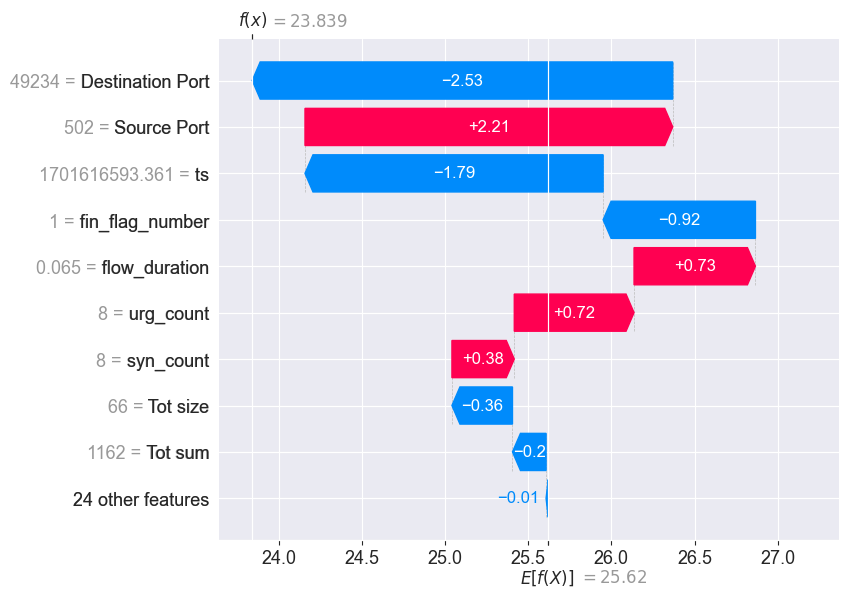

Waterfall Plot for Sample 2, Predicted Class = 0, Probability = 1.00


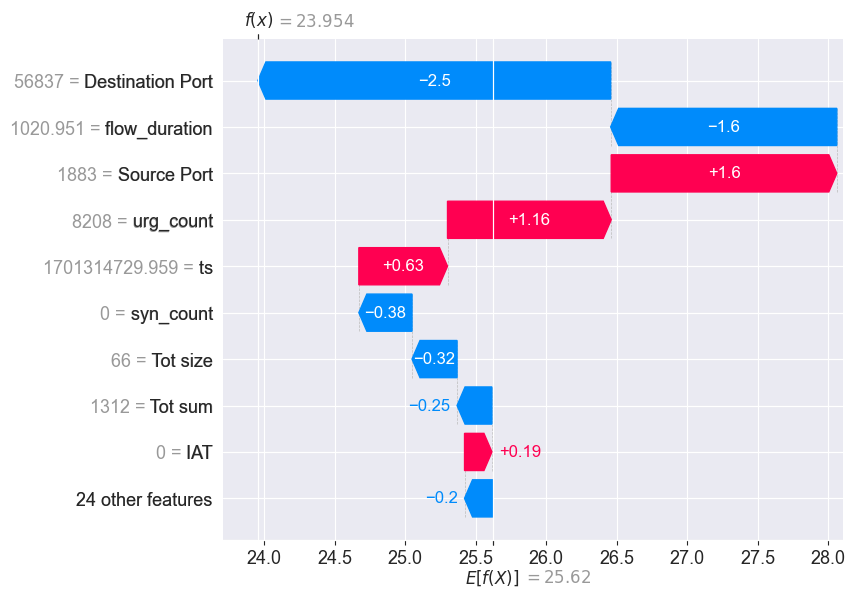

Waterfall Plot for Sample 3, Predicted Class = 0, Probability = 1.00


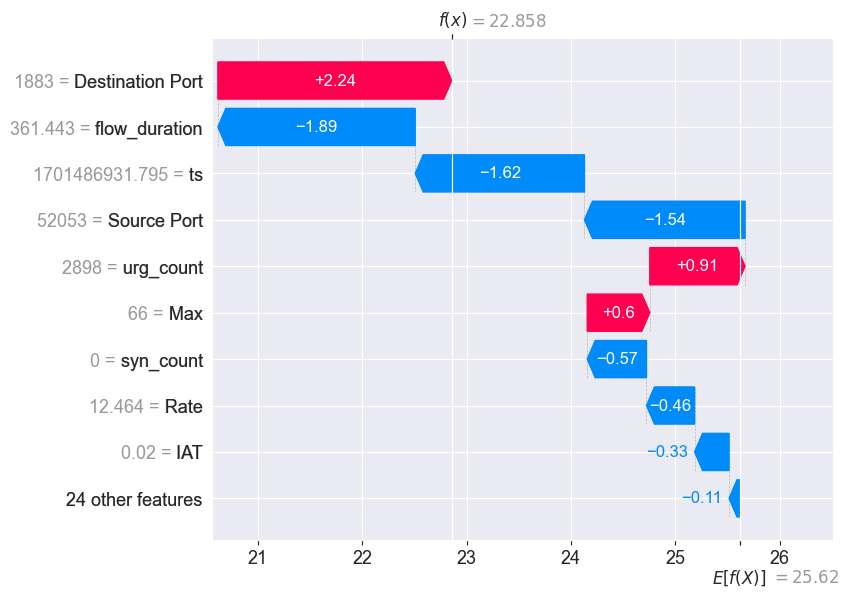

Waterfall Plot for Sample 4, Predicted Class = 0, Probability = 1.00


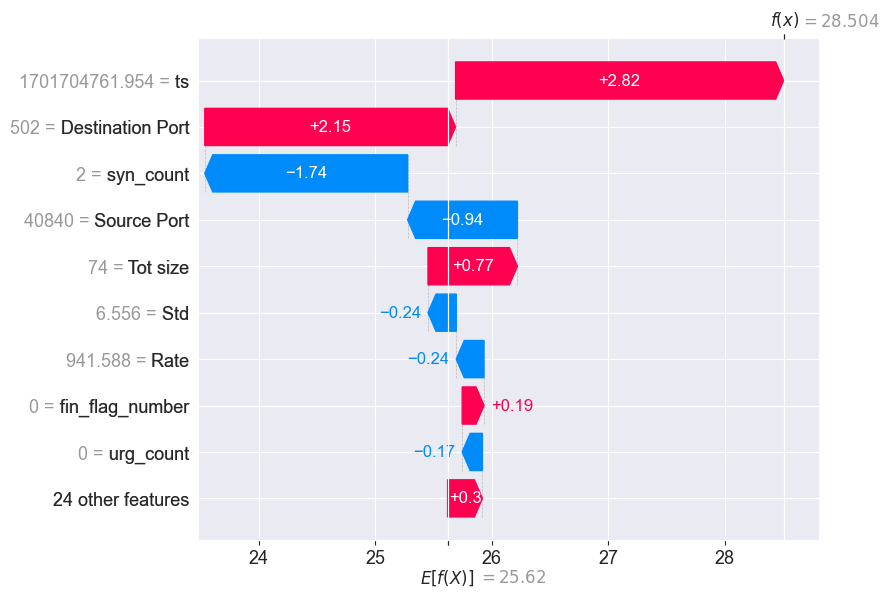

Waterfall Plot for Sample 5, Predicted Class = 0, Probability = 1.00


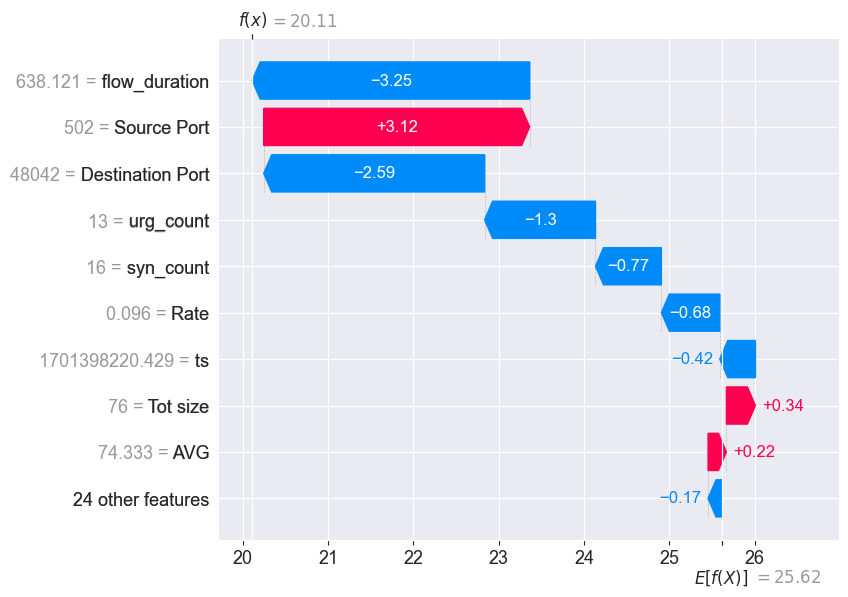

Waterfall Plot for Sample 6, Predicted Class = 0, Probability = 1.00


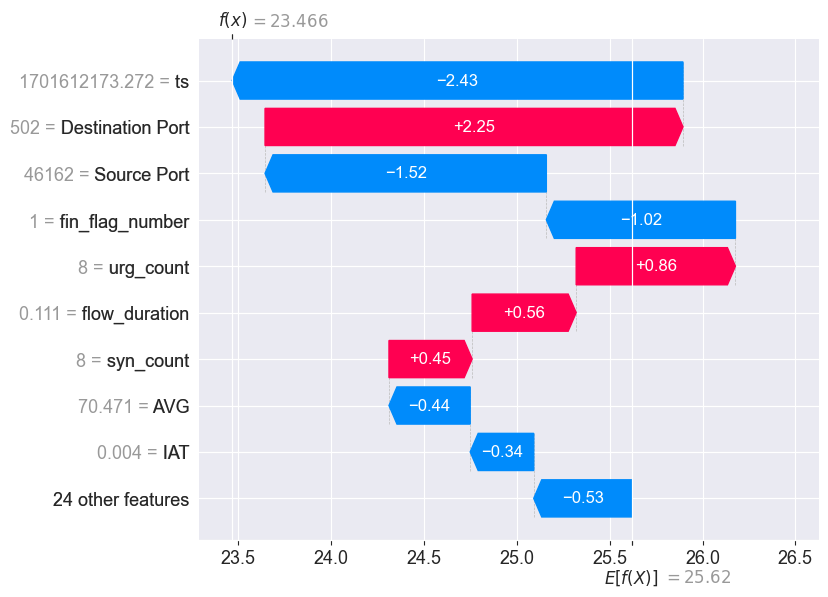

Waterfall Plot for Sample 7, Predicted Class = 0, Probability = 1.00


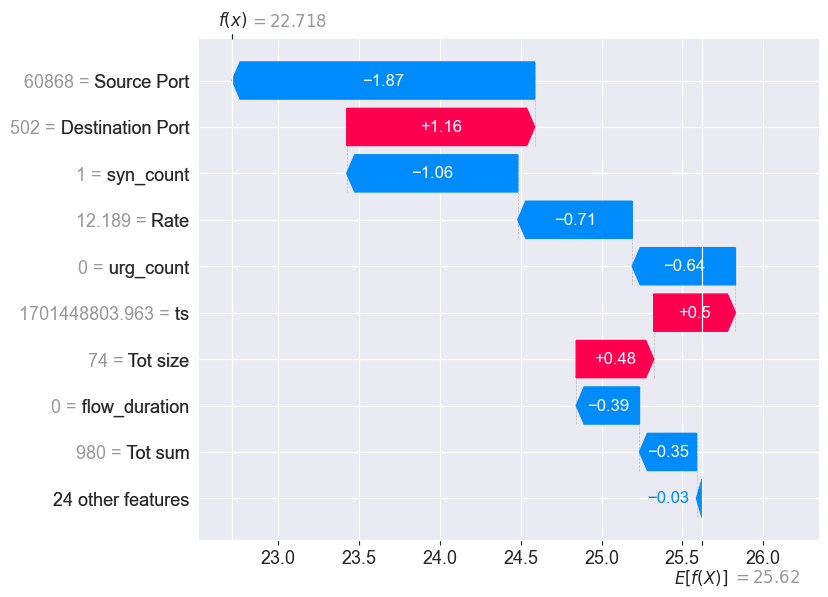

Waterfall Plot for Sample 8, Predicted Class = 0, Probability = 1.00


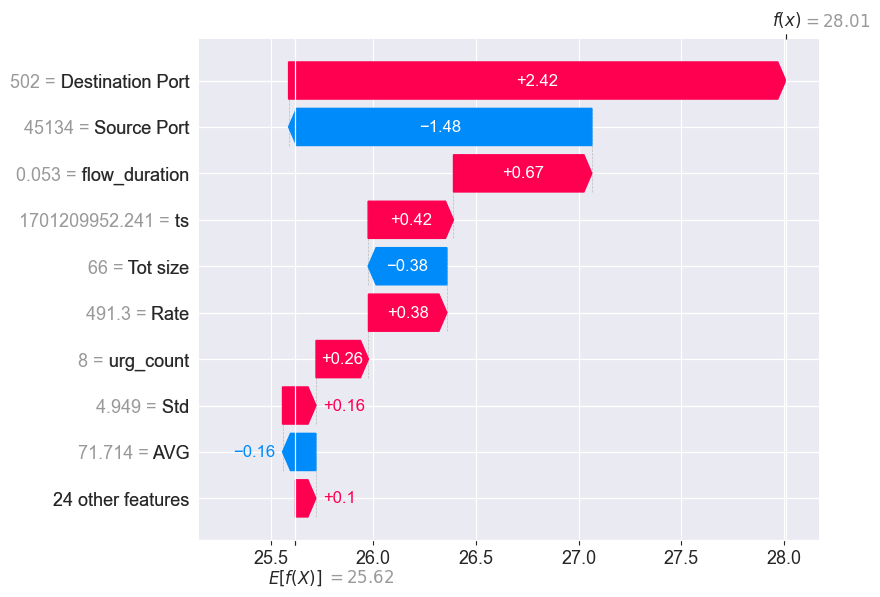

Waterfall Plot for Sample 9, Predicted Class = 0, Probability = 1.00


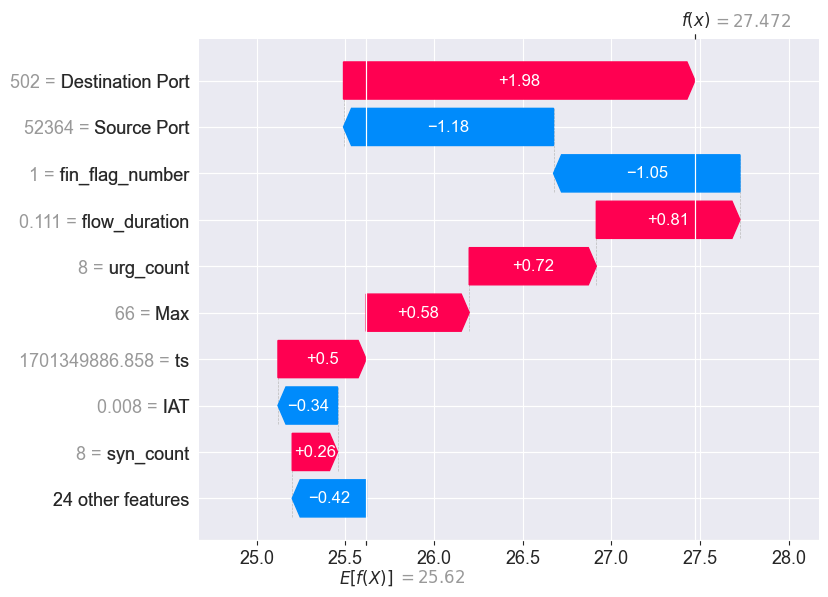

Waterfall Plot for Sample 10, Predicted Class = 0, Probability = 1.00


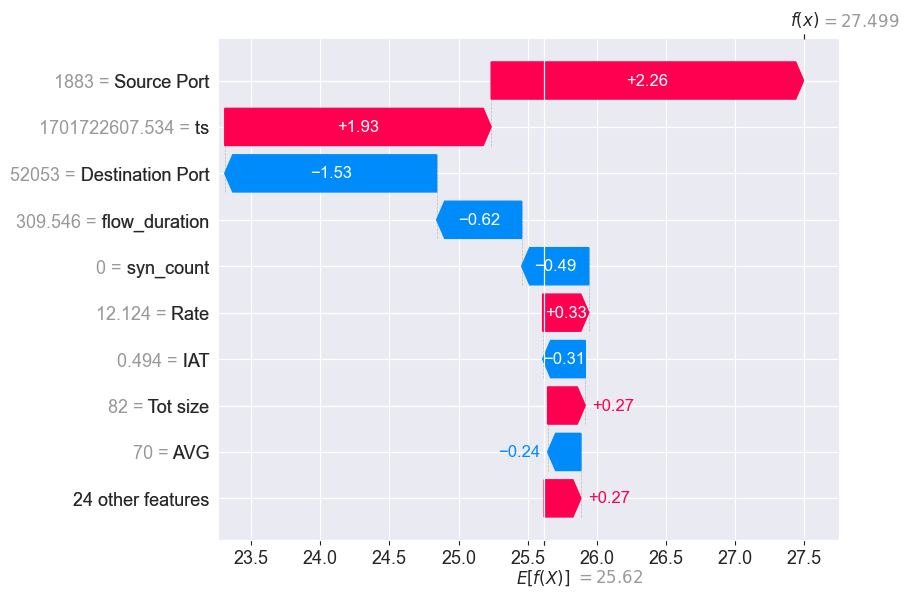

In [26]:
import shap
import numpy as np

probas = model.predict_proba(X_test)

for i in range(10):
    predicted_class = np.argmax(probas[i])
    prediction_proba = probas[i][predicted_class]

    print(f"Waterfall Plot for Sample {i + 1}, Predicted Class = {predicted_class}, Probability = {prediction_proba:.2f}")

    shap.waterfall_plot(
        shap.Explanation(values=shap_values[predicted_class][i], base_values=explainer.expected_value[predicted_class], data=X_test.iloc[i])
    )


Waterfall Plot for Sample 1 (Class 0), Probability = 1.00


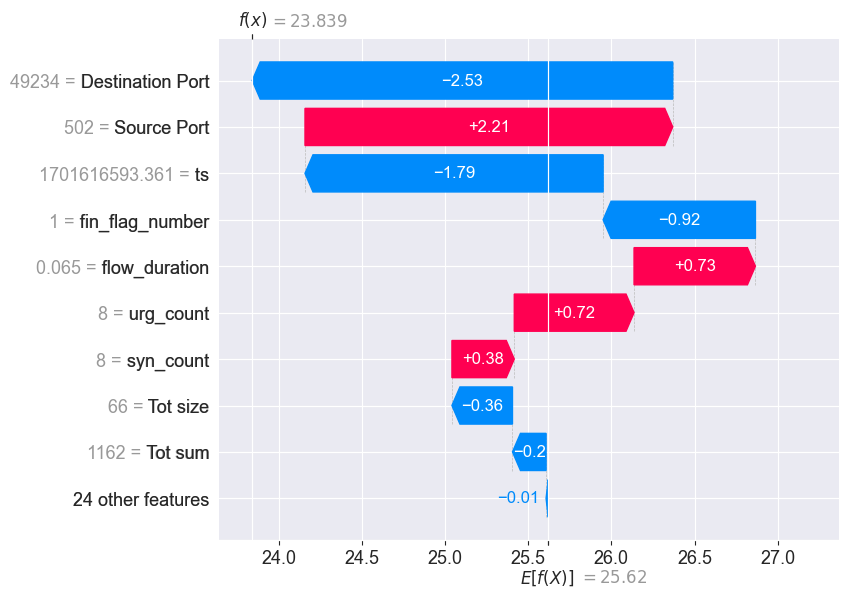

Waterfall Plot for Sample 5852 (Class 1), Probability = 1.00


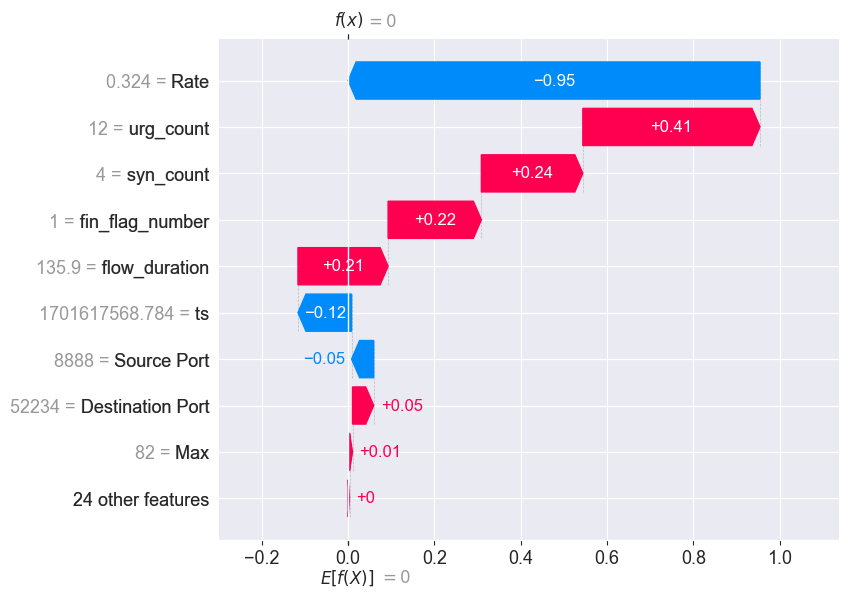

In [27]:
import shap
import numpy as np

probas = model.predict_proba(X_test)

class_0_shown = False
class_1_shown = False

for i in range(len(X_test)):
    predicted_class = np.argmax(probas[i])
    prediction_proba = probas[i][predicted_class]

    if predicted_class == 0 and not class_0_shown:
        print(f"Waterfall Plot for Sample {i + 1} (Class 0), Probability = {prediction_proba:.2f}")
        shap.waterfall_plot(
            shap.Explanation(values=shap_values[0][i], base_values=explainer.expected_value[0], data=X_test.iloc[i])
        )
        class_0_shown = True

    elif predicted_class == 1 and not class_1_shown:
        print(f"Waterfall Plot for Sample {i + 1} (Class 1), Probability = {prediction_proba:.2f}")
        shap.waterfall_plot(
            shap.Explanation(values=shap_values[1][i], base_values=explainer.expected_value[1], data=X_test.iloc[i])
        )
        class_1_shown = True

    if class_0_shown and class_1_shown:
        break


In [68]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def calculate_latency(model, X_test,  iterations=10):
  """
    Average Prediction Latency Per Sample

    Args:
      model: Trained model with .predict method.
      X_test: Test data.
      iterations: Number of iterations to average latency over.
    Returns:
      average_latency_per_row: The average latency per row across all iterations
  """
  total_latency = 0
  num_rows = X_test.shape[0]

  for _ in range(iterations):
      start_time = time.time()

      X_test_prep = X_test.copy()

      # Prediction step
      model.predict(X_test_prep)

      end_time = time.time()
      total_latency += (end_time - start_time)

  average_latency = total_latency / iterations
  average_latency_per_row = average_latency / num_rows
  return average_latency_per_row

In [84]:
average_latency_cat = calculate_latency(model, X_test)
average_latency_cat

6.482104919315503e-07

In [86]:
import psutil
import os
import time

def measure_prediction_memory_cost(model, X_test):
    """
    Memory Usage During Prediction on Test Set (MB)

    Args:
      model: Trained model with .predict method.
      X_test: Test data.
    Returns:
      memory_usage_mb: The increase in memory usage during the prediction, in MB.
    """
    def get_memory_usage():
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / (1024 ** 2)  # in MB

    start_memory = get_memory_usage()
    model.predict(X_test)
    end_memory = get_memory_usage()

    memory_usage_mb = end_memory - start_memory
    return memory_usage_mb



In [89]:
memory_cost = measure_prediction_memory_cost(model, X_test)
print(f"Memory usage during prediction: {memory_cost:.2f} MB")

Memory usage during prediction: 0.01 MB


In [94]:
import psutil
import os
import time

def measure_prediction_cpu_cost(model, X_test, duration=3):
    """
    Average CPU Usage During Prediction on Test Set (%)
    System CPU time during prediction on  Test Set (seconds)

    Args:
      model: Trained model with .predict method.
      X_test: Test data.
      duration : time in seconds to average cpu metrics over.
    Returns:
        cpu_percent: Average CPU usage percentage during prediction.
        user_cpu_time: User CPU time in seconds during the prediction.
        system_cpu_time: System CPU time in seconds during the prediction.
    """

    def get_cpu_usage():
      cpu_percent = psutil.cpu_percent()
      cpu_times = psutil.cpu_times()
      return cpu_percent, cpu_times.user, cpu_times.system

    cpu_usage_list = []
    user_cpu_time_list = []
    system_cpu_time_list = []

    start_time = time.time()
    while time.time() - start_time <= duration:
      cpu_percent, user_time, system_time = get_cpu_usage()
      cpu_usage_list.append(cpu_percent)
      user_cpu_time_list.append(user_time)
      system_cpu_time_list.append(system_time)
      time.sleep(0.1) # Check cpu every 0.1 second

    start_cpu_percent, start_user_time, start_system_time = get_cpu_usage()

    start_prediction_time = time.time()
    model.predict(X_test)
    end_prediction_time = time.time()

    cpu_percent, end_user_time, end_system_time = get_cpu_usage()

    total_user_time = end_user_time - start_user_time
    total_system_time = end_system_time - start_system_time

    return np.mean(cpu_usage_list), total_user_time, total_system_time




In [101]:
cpu_percent, user_cpu_time, system_cpu_time = measure_prediction_cpu_cost(model, X_test)
print(f"Average CPU usage during prediction: {cpu_percent:.2f}%")
print(f"User CPU time during prediction: {user_cpu_time:.2f} seconds")
print(f"System CPU time during prediction: {system_cpu_time:.2f} seconds")

Average CPU usage during prediction: 1.20%
User CPU time during prediction: 51.38 seconds
System CPU time during prediction: 1.05 seconds


In [103]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import psutil
import os

def measure_prediction_scalability(model, X, y, test_size = 0.2, sizes = np.linspace(0.1, 1, 10), iterations = 3):
    """
    Measures scalability

    Args:
      model: Trained model with .predict method.
      X: Full Input dataframe.
      y: Full labels of the dataframe.
      test_size: size of the test set.
      sizes: Fractions of test data to evaluate over.
      iterations: Number of iterations to average over.
    Returns:
      sizes: Fraction of test data used in each run
      prediction_times: time taken to do predictions with each fraction of test data
    """
    prediction_times = []
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_size, random_state=42)

    for size in sizes:
        subset_size = int(len(X_test1) * size)
        X_test_subset = X_test1[:subset_size]


        total_prediction_time = 0
        for _ in range(iterations):
             start_time = time.time()
             model.predict(X_test_subset)
             end_time = time.time()
             total_prediction_time += (end_time-start_time)
        prediction_time = total_prediction_time/iterations


        prediction_times.append(prediction_time)

    return sizes, prediction_times




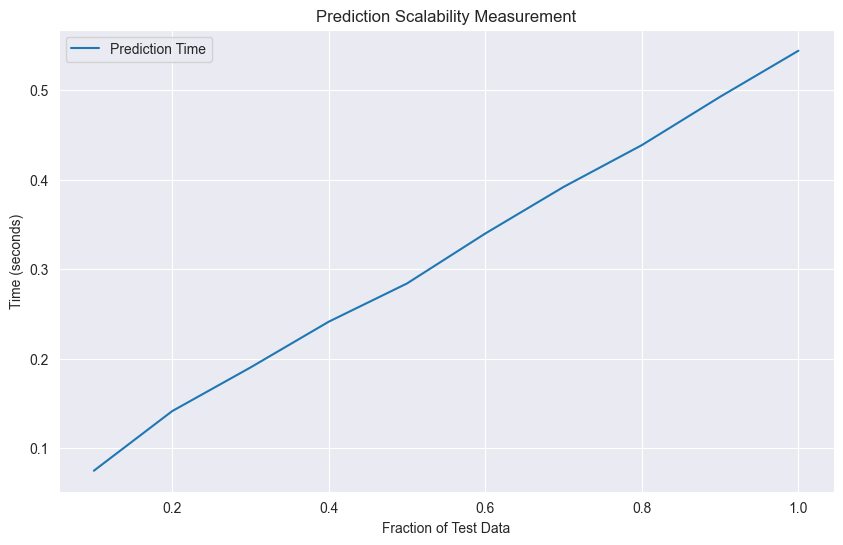

In [106]:
sizes, prediction_times = measure_prediction_scalability(model, X_test, y_test)
#
plt.figure(figsize=(10, 6))
plt.plot(sizes, prediction_times, label='Prediction Time')
plt.xlabel('Fraction of Test Data')
plt.ylabel('Time (seconds)')
plt.title('Prediction Scalability Measurement')
plt.legend()
plt.grid(True)
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


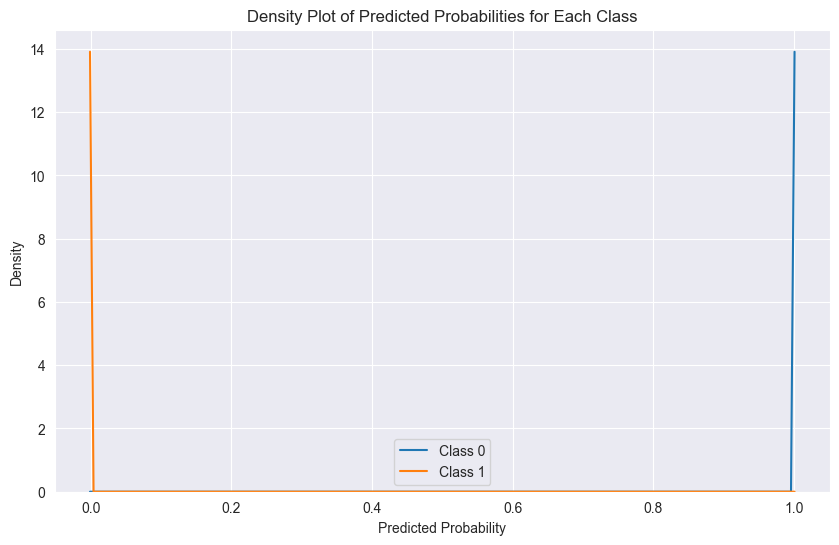

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1000x600 with 0 Axes>

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve
import numpy as np

if hasattr(model, "predict_proba"):
    y_pred_proba1 = model.predict_proba(X_test)
    plt.figure(figsize=(10, 6))
    for i in range(y_pred_proba1.shape[1]):
        sns.kdeplot(y_pred_proba1[:, i], label=f'Class {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Density Plot of Predicted Probabilities for Each Class')
    plt.legend()
    plt.show()



plt.figure(figsize=(10, 6))
for i in range(y_pred_proba1.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {i}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.show()

In [110]:
probabilities1 = model.predict_proba(X_test)

confidence_scores = probabilities1[:, 1]

# عرض النتائج
for i, score in enumerate(confidence_scores):
    print(f"Sample {i + 1}: Confidence Score = {score:.2f}")


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



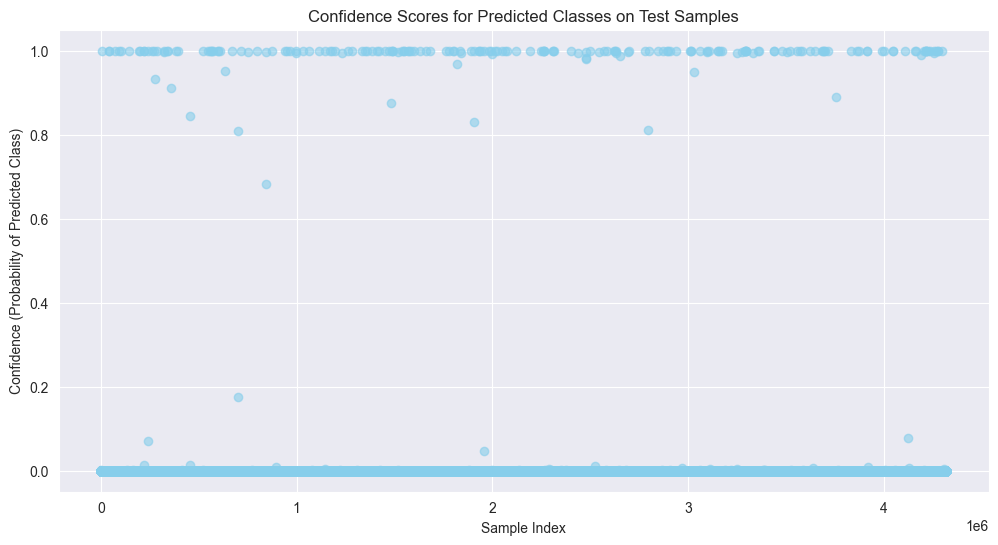

In [111]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(confidence_scores)), confidence_scores, color='skyblue', alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Confidence (Probability of Predicted Class)")
plt.title("Confidence Scores for Predicted Classes on Test Samples")
plt.show()


In [112]:
confidence_scores

array([4.43488579e-11, 3.95302178e-11, 1.18271749e-10, ...,
       4.80285169e-11, 2.94980264e-12, 3.51946260e-13])

In [116]:
probabilities1 = model.predict_proba(X_test)

confidence_scores = probabilities1.max(axis=1) * 100

high_confidence_count = sum(confidence_scores > 99.99)

total_samples = len(confidence_scores)
percentage_high_confidence = (high_confidence_count / total_samples) * 100

print(f"Percentage of samples with confidence > 99.99%: {percentage_high_confidence:.6f}%")


Percentage of samples with confidence > 99.99%: 99.994004%


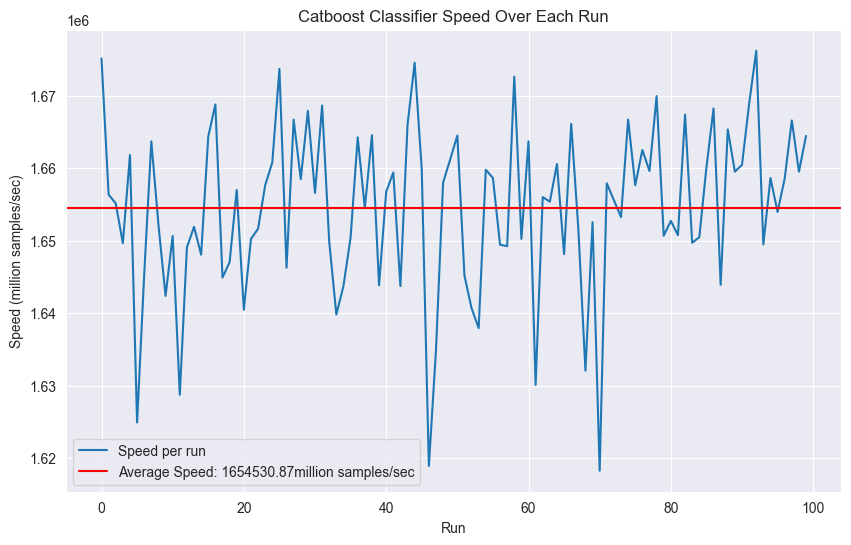

In [31]:
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd

total_elapsed_time = 0
total_samples = 0

num_runs = 100  # Define how many times you want to run the prediction
speeds = []  # List to hold the speed for each run

for _ in range(num_runs):

    if isinstance(X_test, np.ndarray):
        np.random.shuffle(X_test)  # Simple shuffling of samples

    elif isinstance(X_test, pd.DataFrame):
        X_test = X_test.sample(frac=1).reset_index(drop=True)

    start_time = time.time()
    predictions = model.predict(X_test)
    end_time = time.time()

    elapsed_time = end_time - start_time  # Time taken to make predictions in this run
    total_elapsed_time += elapsed_time  # Accumulating total elapsed time over all runs

    samples = X_test.shape[0]  # Number of samples in this run
    total_samples += samples  # Accumulating total number of samples over all runs

    speed = samples / elapsed_time  # Calculate speed in samples/sec for the current run
    speeds.append(speed)  # Append current speed to the list

# Calculating average speed
average_speed = total_samples / total_elapsed_time  # Calculate speed in samples/sec

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(speeds, label="Speed per run")  # Plotting speed for each run
plt.axhline(y=average_speed, color='r', linestyle='-', label=f"Average Speed: {average_speed:.2f}million samples/sec")
plt.title("Catboost Classifier Speed Over Each Run")
plt.xlabel("Run")
plt.ylabel("Speed (million samples/sec)")
plt.legend()
plt.show()


In [3]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

model = CatBoostClassifier(
    iterations=1300,
    learning_rate=0.2,
    depth=9,
    loss_function='MultiClass',
    task_type='GPU',
    verbose=0,
    random_seed=42,
    l2_leaf_reg=2,
    border_count=512,
    early_stopping_rounds=150,
    eval_metric='TotalF1',
    leaf_estimation_iterations=10,
    bagging_temperature=1.0
)

# Set up stratified k-fold cross-validation (k=5)
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to hold all the results from the cross-validation
all_precisions = []
all_recalls = []
all_f1s = []

# Perform stratified k-fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}/{n_splits}")

    # Split the data into training and test sets for each fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reset index for y_train and y_test:
    y_train = y_train
    y_test = y_test


    # Train the model
    model.fit(X_train, y_train, verbose=0)

    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)


# Calculate the mean performance metrics across folds
mean_precision = np.mean(all_precisions)
mean_recall = np.mean(all_recalls)
mean_f1 = np.mean(all_f1s)

print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")



y_pred_all_training_set = model.predict_proba(X)

print(y_pred_all_training_set)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Mean Precision: 1.0000
Mean Recall: 1.0000
Mean F1-Score: 1.0000
[[1.00000000e+00 2.58723657e-10]
 [1.00000000e+00 1.44337428e-10]
 [1.00000000e+00 8.70416060e-11]
 ...
 [1.00000000e+00 3.43849516e-11]
 [1.00000000e+00 2.80290107e-11]
 [1.00000000e+00 1.53504462e-11]]
